**Handle Door and Door Detection & Localization Model using YOLO NAS Architecture**
/(Add a short introduction later)

##**Steps of the Notebook**



*   Requirements




#**Requirements**
It is desired to ensure that the GPU Accelerator is being used in this notebook, in order to have significally speed up model training times. nvidia-smi command will be used for do that.

In [ ]:
!nvidia-smi

Thu Nov 23 18:41:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Installing YOLO-NAS

In [ ]:
%%capture
!pip install -q git+https://github.com/Deci-AI/super-gradients.git@stable
!pip install -q super-gradients==3.2.0
!pip install -q roboflow
!pip install -q supervision

Reset RunTime

##Dataset
In this project was use Roboflow for the process of create the Data Base and take data from other repositories.

For create the Data Base, it was recorder door and hande door in The UJI and then processed in Roboflow software. In the next steps:


*   Upload Data
*   Make the Localization with the Boundig Box
*   Make the Detection
*   Make labeling - Classes
*   Split th data set for train the model (Train, Valid & Test)
*   Making Preprocessing Data (image transformation)
*   Making Data Augmentation
*   Exporting data in YOLOV5 Pytorch Format




Here the data set is downloaded with your labels and organized in each folder (Training, Test & Validation)


In [ ]:
#Dataset Just for Training & Valid (versin 10 Roboflow)
from roboflow import Roboflow
rf = Roboflow(api_key="XXXXXX")
project = rf.workspace("laura-munoz").project("door-handle-detection")
dataset = project.version(10).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Door-handle-detection-10 in yolov5pytorch:: 100%|██████████| 5453/5453 [00:01<00:00, 3501.79it/s]


In [ ]:
#Dataset Just for test

rf_t = Roboflow(api_key="XXXXXXX")
project_t = rf_t.workspace("laura-munoz").project("test_door_handle_detection")
dataset_t = project_t.version(2).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Test_Door_Handle_Detection-2 in yolov5pytorch:: 100%|██████████| 312/312 [00:00<00:00, 5404.72it/s]


## Class Definition

In [ ]:
from typing import List, Dict
class config:
    # Project paths
    DATA_DIR: str = "/content/Door-handle-detection-10"
    CHECKPOINT_DIR: str = "/content/checkpoints"
    EXPERIMENT_NAME: str = "tesis_detection_localization_model_yoloNAS_L"

    # Datasets
    TRAIN_IMAGES_DIR: str = "/content/Door-handle-detection-10/train/images"
    TRAIN_LABELS_DIR: str = "/content/Door-handle-detection-10/train/labels"
    VAL_IMAGES_DIR: str = "/content/Door-handle-detection-10/valid/images"
    VAL_LABELS_DIR: str = "/content/Door-handle-detection-10/valid/labels"
    TEST_IMAGES_DIR: str = "/content/Test_Door_Handle_Detection-2/test/images"
    TEST_LABELS_DIR: str = "/content/Test_Door_Handle_Detection-2/test/labels"

    # Classes
    CLASSES: List[str] = ['Door','Handle-Door']
    NUM_CLASSES: int = len(CLASSES)

    # Model
    DATALOADER_PARAMS: Dict = {
      'batch_size': 16,
      'num_workers': 1
    }
    MODEL_NAME: str = 'yolo_nas_l'
    PRETRAINED_WEIGHTS: str = 'coco'

##DataLouders initialization

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_val


[2023-11-23 18:48:22] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-11-23 18:48:24] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-11-23 18:48:26] WARNING - __init__.py - Failed to import pytorch_quantization
Setuptools is replacing distutils.
[2023-11-23 18:48:30] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-23 18:48:30] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-23 18:48:30] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2023-11-23 18:49:08] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2499/2499 [00:00<00:00, 7006.70it/s]
[2023-11-23 18:49:09] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 153/153 [00:00<00:00, 4823.10it/s]
[2023-11-23 18:49:09] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 223/223 [00:00<00:00, 5745.16it/s]
[2023-11-23 18:49:09] WARNING - detection_dataset.py - Found 1 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.


In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

##Visualization

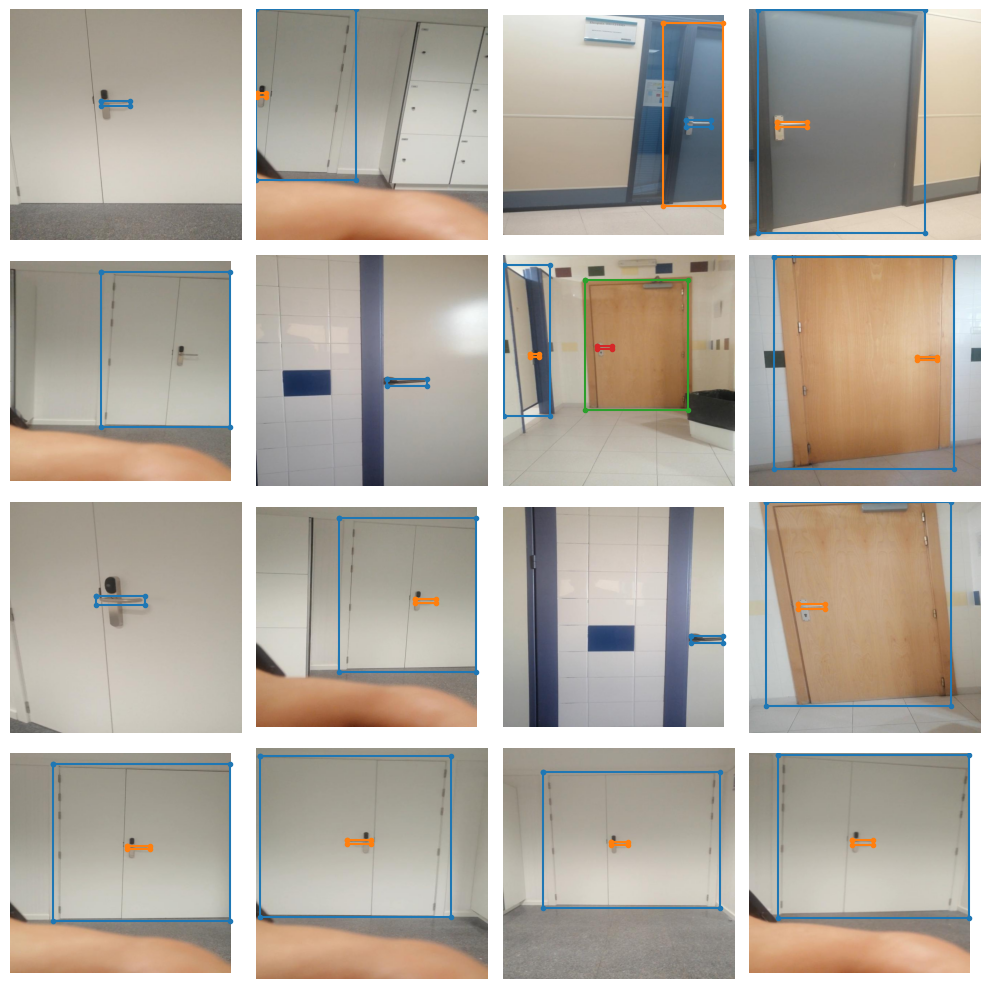

In [ ]:
val_data.dataset.plot()

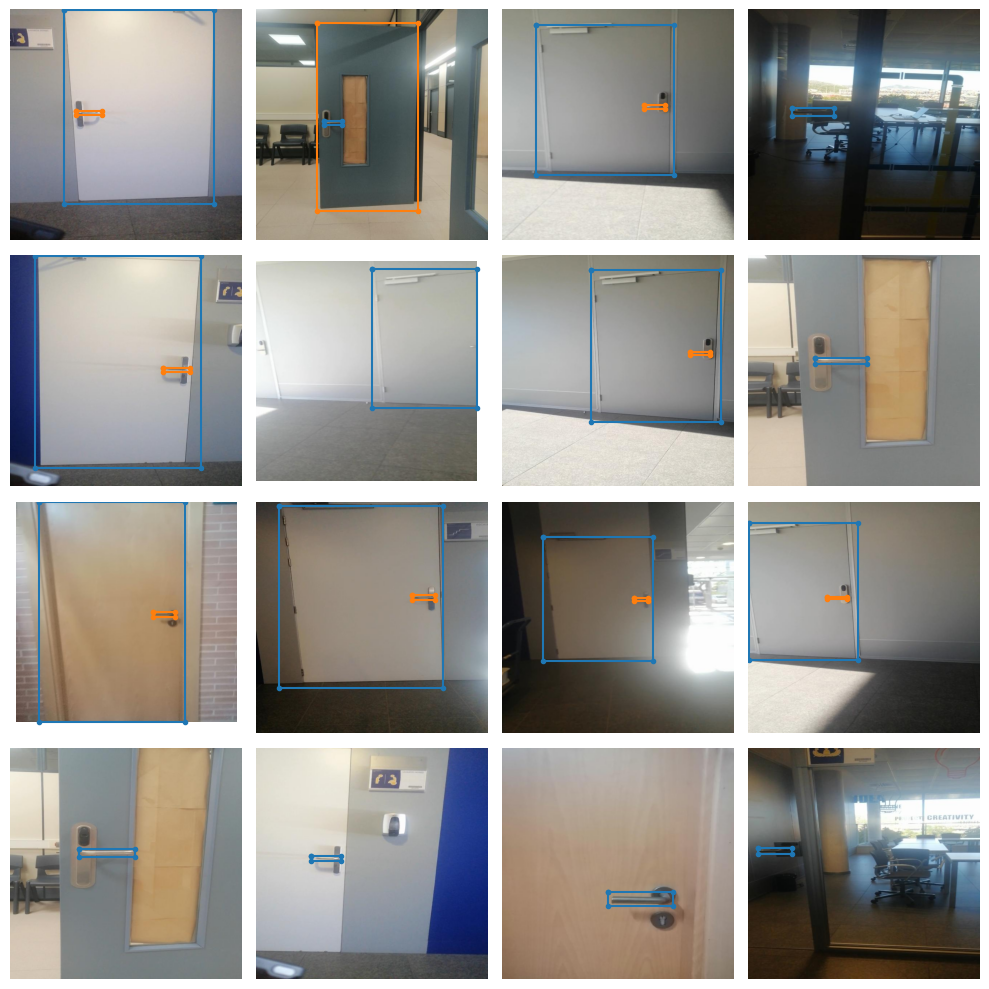

In [ ]:
test_data.dataset.plot()

##Training hyperparameters

Estudiar a fondo los hiperparametros y ver cuales vale la pea modificar, si es que se pueden modificar

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 30,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

##Training Model

In [ ]:
# Model Download. Yolo-NAS_L Model is downloaded
from super_gradients.training import models
model = models.get(config.MODEL_NAME, #YOLO_NAS_L
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS)  #PRETRAINED_WEIGHTS = "coco"

[2023-11-23 18:49:26] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:00<00:00, 288MB/s]
[2023-11-23 18:49:28] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [ ]:
#Trainer Initializating
#Experiment name (described before), and in checkpoints will be saved (Betters results, average, ephocs, weigths, mAP (mil Average Presicion))
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME,
                  ckpt_root_dir=config.CHECKPOINT_DIR)

In [ ]:
#Train
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/console_Nov23_18_49_47.txt


[2023-11-23 18:49:48] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-11-23 18:49:50] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2499       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         156        (len(train_loader))
    - Gradient updates per epoch:   156        (len(train_loader) / batch_accumulate)

[2023-11-23 18:49:50] INFO - sg_trainer.py - Started training for 25 epochs (0/24)

Validating: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
[2023-11-23 18:54:14] INFO - base_sg_logger.py 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.8584
│   ├── Ppyoloeloss/loss_iou = 0.2805
│   ├── Ppyoloeloss/loss_dfl = 1.5756
│   └── Ppyoloeloss/loss = 3.3476
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.8342
    ├── Ppyoloeloss/loss_iou = 0.2129
    ├── Ppyoloeloss/loss_dfl = 1.3283
    ├── Ppyoloeloss/loss = 3.0306
    ├── Precision@0.50 = 0.1168
    ├── Recall@0.50 = 0.3208
    ├── Map@0.50 = 0.1291
    └── F1@0.50 = 0.1487



Validating epoch 1: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
[2023-11-23 18:58:28] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 18:58:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6745487451553345


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1243
│   │   ├── Epoch N-1      = 1.8584 (↘ -0.7342)
│   │   └── Best until now = 1.8584 (↘ -0.7342)
│   ├── Ppyoloeloss/loss_iou = 0.2048
│   │   ├── Epoch N-1      = 0.2805 (↘ -0.0758)
│   │   └── Best until now = 0.2805 (↘ -0.0758)
│   ├── Ppyoloeloss/loss_dfl = 1.2609
│   │   ├── Epoch N-1      = 1.5756 (↘ -0.3147)
│   │   └── Best until now = 1.5756 (↘ -0.3147)
│   └── Ppyoloeloss/loss = 2.2667
│       ├── Epoch N-1      = 3.3476 (↘ -1.0809)
│       └── Best until now = 3.3476 (↘ -1.0809)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9724
    │   ├── Epoch N-1      = 1.8342 (↘ -0.8618)
    │   └── Best until now = 1.8342 (↘ -0.8618)
    ├── Ppyoloeloss/loss_iou = 0.1809
    │   ├── Epoch N-1      = 0.2129 (↘ -0.032)
    │   └── Best until now = 0.2129 (↘ -0.032)
    ├── Ppyoloeloss/loss_dfl = 1.0855
    │   ├── Epoch N-1      = 1.3283 (↘ -0.2428)
    │   └── Best until now = 1.3283 (↘ -0.2428)
    ├── Ppyoloeloss/loss

Validating epoch 2: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0351
│   │   ├── Epoch N-1      = 1.1243 (↘ -0.0892)
│   │   └── Best until now = 1.1243 (↘ -0.0892)
│   ├── Ppyoloeloss/loss_iou = 0.1971
│   │   ├── Epoch N-1      = 0.2048 (↘ -0.0077)
│   │   └── Best until now = 0.2048 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 1.1989
│   │   ├── Epoch N-1      = 1.2609 (↘ -0.062)
│   │   └── Best until now = 1.2609 (↘ -0.062)
│   └── Ppyoloeloss/loss = 2.1273
│       ├── Epoch N-1      = 2.2667 (↘ -0.1394)
│       └── Best until now = 2.2667 (↘ -0.1394)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9756
    │   ├── Epoch N-1      = 0.9724 (↗ 0.0033)
    │   └── Best until now = 0.9724 (↗ 0.0033)
    ├── Ppyoloeloss/loss_iou = 0.1965
    │   ├── Epoch N-1      = 0.1809 (↗ 0.0157)
    │   └── Best until now = 0.1809 (↗ 0.0157)
    ├── Ppyoloeloss/loss_dfl = 1.0776
    │   ├── Epoch N-1      = 1.0855 (↘ -0.0079)
    │   └── Best until now = 1.0855 (↘ -0.0079)
    ├── Ppyoloeloss/loss = 2

Validating epoch 3: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
[2023-11-23 19:07:06] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 19:07:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8039720058441162


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0053
│   │   ├── Epoch N-1      = 1.0351 (↘ -0.0297)
│   │   └── Best until now = 1.0351 (↘ -0.0297)
│   ├── Ppyoloeloss/loss_iou = 0.1953
│   │   ├── Epoch N-1      = 0.1971 (↘ -0.0018)
│   │   └── Best until now = 0.1971 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 1.1943
│   │   ├── Epoch N-1      = 1.1989 (↘ -0.0046)
│   │   └── Best until now = 1.1989 (↘ -0.0046)
│   └── Ppyoloeloss/loss = 2.0908
│       ├── Epoch N-1      = 2.1273 (↘ -0.0364)
│       └── Best until now = 2.1273 (↘ -0.0364)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2181
    │   ├── Epoch N-1      = 0.9756 (↗ 0.2424)
    │   └── Best until now = 0.9724 (↗ 0.2457)
    ├── Ppyoloeloss/loss_iou = 0.1939
    │   ├── Epoch N-1      = 0.1965 (↘ -0.0026)
    │   └── Best until now = 0.1809 (↗ 0.0131)
    ├── Ppyoloeloss/loss_dfl = 1.1267
    │   ├── Epoch N-1      = 1.0776 (↗ 0.049)
    │   └── Best until now = 1.0776 (↗ 0.049)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 4: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
[2023-11-23 19:11:48] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 19:11:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8243191242218018


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9751
│   │   ├── Epoch N-1      = 1.0053 (↘ -0.0302)
│   │   └── Best until now = 1.0053 (↘ -0.0302)
│   ├── Ppyoloeloss/loss_iou = 0.1888
│   │   ├── Epoch N-1      = 0.1953 (↘ -0.0065)
│   │   └── Best until now = 0.1953 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_dfl = 1.1657
│   │   ├── Epoch N-1      = 1.1943 (↘ -0.0286)
│   │   └── Best until now = 1.1943 (↘ -0.0286)
│   └── Ppyoloeloss/loss = 2.03
│       ├── Epoch N-1      = 2.0908 (↘ -0.0609)
│       └── Best until now = 2.0908 (↘ -0.0609)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.978
    │   ├── Epoch N-1      = 1.2181 (↘ -0.2401)
    │   └── Best until now = 0.9724 (↗ 0.0056)
    ├── Ppyoloeloss/loss_iou = 0.1828
    │   ├── Epoch N-1      = 0.1939 (↘ -0.0111)
    │   └── Best until now = 0.1809 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 1.0902
    │   ├── Epoch N-1      = 1.1267 (↘ -0.0365)
    │   └── Best until now = 1.0776 (↗ 0.0125)
    ├── Ppyoloeloss/loss = 1

Validating epoch 5: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9516
│   │   ├── Epoch N-1      = 0.9751 (↘ -0.0235)
│   │   └── Best until now = 0.9751 (↘ -0.0235)
│   ├── Ppyoloeloss/loss_iou = 0.184
│   │   ├── Epoch N-1      = 0.1888 (↘ -0.0048)
│   │   └── Best until now = 0.1888 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_dfl = 1.1341
│   │   ├── Epoch N-1      = 1.1657 (↘ -0.0316)
│   │   └── Best until now = 1.1657 (↘ -0.0316)
│   └── Ppyoloeloss/loss = 1.9786
│       ├── Epoch N-1      = 2.03   (↘ -0.0514)
│       └── Best until now = 2.03   (↘ -0.0514)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0488
    │   ├── Epoch N-1      = 0.978  (↗ 0.0708)
    │   └── Best until now = 0.9724 (↗ 0.0764)
    ├── Ppyoloeloss/loss_iou = 0.1804
    │   ├── Epoch N-1      = 0.1828 (↘ -0.0024)
    │   └── Best until now = 0.1809 (↘ -0.0004)
    ├── Ppyoloeloss/loss_dfl = 1.0552
    │   ├── Epoch N-1      = 1.0902 (↘ -0.035)
    │   └── Best until now = 1.0776 (↘ -0.0225)
    ├── Ppyoloeloss/loss =

Validating epoch 6: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.941
│   │   ├── Epoch N-1      = 0.9516 (↘ -0.0106)
│   │   └── Best until now = 0.9516 (↘ -0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.1819
│   │   ├── Epoch N-1      = 0.184  (↘ -0.0021)
│   │   └── Best until now = 0.184  (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 1.1315
│   │   ├── Epoch N-1      = 1.1341 (↘ -0.0026)
│   │   └── Best until now = 1.1341 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 1.9614
│       ├── Epoch N-1      = 1.9786 (↘ -0.0171)
│       └── Best until now = 1.9786 (↘ -0.0171)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9531
    │   ├── Epoch N-1      = 1.0488 (↘ -0.0956)
    │   └── Best until now = 0.9724 (↘ -0.0192)
    ├── Ppyoloeloss/loss_iou = 0.1705
    │   ├── Epoch N-1      = 0.1804 (↘ -0.0099)
    │   └── Best until now = 0.1804 (↘ -0.0099)
    ├── Ppyoloeloss/loss_dfl = 1.0214
    │   ├── Epoch N-1      = 1.0552 (↘ -0.0338)
    │   └── Best until now = 1.0552 (↘ -0.0338)
    ├── Ppyoloeloss/los

Validating epoch 7: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
[2023-11-23 19:26:24] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 19:26:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8273141980171204


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9269
│   │   ├── Epoch N-1      = 0.941  (↘ -0.0141)
│   │   └── Best until now = 0.941  (↘ -0.0141)
│   ├── Ppyoloeloss/loss_iou = 0.1789
│   │   ├── Epoch N-1      = 0.1819 (↘ -0.003)
│   │   └── Best until now = 0.1819 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 1.1087
│   │   ├── Epoch N-1      = 1.1315 (↘ -0.0227)
│   │   └── Best until now = 1.1315 (↘ -0.0227)
│   └── Ppyoloeloss/loss = 1.9285
│       ├── Epoch N-1      = 1.9614 (↘ -0.0329)
│       └── Best until now = 1.9614 (↘ -0.0329)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0713
    │   ├── Epoch N-1      = 0.9531 (↗ 0.1182)
    │   └── Best until now = 0.9531 (↗ 0.1182)
    ├── Ppyoloeloss/loss_iou = 0.1793
    │   ├── Epoch N-1      = 0.1705 (↗ 0.0087)
    │   └── Best until now = 0.1705 (↗ 0.0087)
    ├── Ppyoloeloss/loss_dfl = 1.032
    │   ├── Epoch N-1      = 1.0214 (↗ 0.0106)
    │   └── Best until now = 1.0214 (↗ 0.0106)
    ├── Ppyoloeloss/loss = 2.03

Validating epoch 8: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]
[2023-11-23 19:31:19] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 19:31:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8513562083244324


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9052
│   │   ├── Epoch N-1      = 0.9269 (↘ -0.0217)
│   │   └── Best until now = 0.9269 (↘ -0.0217)
│   ├── Ppyoloeloss/loss_iou = 0.1785
│   │   ├── Epoch N-1      = 0.1789 (↘ -0.0004)
│   │   └── Best until now = 0.1789 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 1.1014
│   │   ├── Epoch N-1      = 1.1087 (↘ -0.0073)
│   │   └── Best until now = 1.1087 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 1.9022
│       ├── Epoch N-1      = 1.9285 (↘ -0.0263)
│       └── Best until now = 1.9285 (↘ -0.0263)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9208
    │   ├── Epoch N-1      = 1.0713 (↘ -0.1504)
    │   └── Best until now = 0.9531 (↘ -0.0323)
    ├── Ppyoloeloss/loss_iou = 0.1791
    │   ├── Epoch N-1      = 0.1793 (↘ -0.0002)
    │   └── Best until now = 0.1705 (↗ 0.0085)
    ├── Ppyoloeloss/loss_dfl = 1.0115
    │   ├── Epoch N-1      = 1.032  (↘ -0.0204)
    │   └── Best until now = 1.0214 (↘ -0.0099)
    ├── Ppyoloeloss/los

Validating epoch 9: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]
[2023-11-23 19:36:11] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 19:36:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8681515455245972


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8966
│   │   ├── Epoch N-1      = 0.9052 (↘ -0.0086)
│   │   └── Best until now = 0.9052 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.1731
│   │   ├── Epoch N-1      = 0.1785 (↘ -0.0054)
│   │   └── Best until now = 0.1785 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 1.0842
│   │   ├── Epoch N-1      = 1.1014 (↘ -0.0172)
│   │   └── Best until now = 1.1014 (↘ -0.0172)
│   └── Ppyoloeloss/loss = 1.8714
│       ├── Epoch N-1      = 1.9022 (↘ -0.0308)
│       └── Best until now = 1.9022 (↘ -0.0308)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9193
    │   ├── Epoch N-1      = 0.9208 (↘ -0.0015)
    │   └── Best until now = 0.9208 (↘ -0.0015)
    ├── Ppyoloeloss/loss_iou = 0.1784
    │   ├── Epoch N-1      = 0.1791 (↘ -0.0007)
    │   └── Best until now = 0.1705 (↗ 0.0079)
    ├── Ppyoloeloss/loss_dfl = 1.0148
    │   ├── Epoch N-1      = 1.0115 (↗ 0.0033)
    │   └── Best until now = 1.0115 (↗ 0.0033)
    ├── Ppyoloeloss/loss 

Validating epoch 10: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8844
│   │   ├── Epoch N-1      = 0.8966 (↘ -0.0121)
│   │   └── Best until now = 0.8966 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_iou = 0.172
│   │   ├── Epoch N-1      = 0.1731 (↘ -0.0011)
│   │   └── Best until now = 0.1731 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 1.0719
│   │   ├── Epoch N-1      = 1.0842 (↘ -0.0124)
│   │   └── Best until now = 1.0842 (↘ -0.0124)
│   └── Ppyoloeloss/loss = 1.8503
│       ├── Epoch N-1      = 1.8714 (↘ -0.0211)
│       └── Best until now = 1.8714 (↘ -0.0211)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9617
    │   ├── Epoch N-1      = 0.9193 (↗ 0.0423)
    │   └── Best until now = 0.9193 (↗ 0.0423)
    ├── Ppyoloeloss/loss_iou = 0.1896
    │   ├── Epoch N-1      = 0.1784 (↗ 0.0112)
    │   └── Best until now = 0.1705 (↗ 0.0191)
    ├── Ppyoloeloss/loss_dfl = 1.0146
    │   ├── Epoch N-1      = 1.0148 (↘ -0.0002)
    │   └── Best until now = 1.0115 (↗ 0.0031)
    ├── Ppyoloeloss/loss = 

Validating epoch 11: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
[2023-11-23 19:46:02] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 19:46:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8821310997009277


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8704
│   │   ├── Epoch N-1      = 0.8844 (↘ -0.014)
│   │   └── Best until now = 0.8844 (↘ -0.014)
│   ├── Ppyoloeloss/loss_iou = 0.1698
│   │   ├── Epoch N-1      = 0.172  (↘ -0.0022)
│   │   └── Best until now = 0.172  (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 1.0678
│   │   ├── Epoch N-1      = 1.0719 (↘ -0.0041)
│   │   └── Best until now = 1.0719 (↘ -0.0041)
│   └── Ppyoloeloss/loss = 1.8288
│       ├── Epoch N-1      = 1.8503 (↘ -0.0215)
│       └── Best until now = 1.8503 (↘ -0.0215)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0074
    │   ├── Epoch N-1      = 0.9617 (↗ 0.0458)
    │   └── Best until now = 0.9193 (↗ 0.0881)
    ├── Ppyoloeloss/loss_iou = 0.1765
    │   ├── Epoch N-1      = 0.1896 (↘ -0.0132)
    │   └── Best until now = 0.1705 (↗ 0.0059)
    ├── Ppyoloeloss/loss_dfl = 0.9529
    │   ├── Epoch N-1      = 1.0146 (↘ -0.0617)
    │   └── Best until now = 1.0115 (↘ -0.0586)
    ├── Ppyoloeloss/loss =

Validating epoch 12: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8642
│   │   ├── Epoch N-1      = 0.8704 (↘ -0.0062)
│   │   └── Best until now = 0.8704 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.1684
│   │   ├── Epoch N-1      = 0.1698 (↘ -0.0014)
│   │   └── Best until now = 0.1698 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 1.054
│   │   ├── Epoch N-1      = 1.0678 (↘ -0.0138)
│   │   └── Best until now = 1.0678 (↘ -0.0138)
│   └── Ppyoloeloss/loss = 1.8122
│       ├── Epoch N-1      = 1.8288 (↘ -0.0166)
│       └── Best until now = 1.8288 (↘ -0.0166)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0026
    │   ├── Epoch N-1      = 1.0074 (↘ -0.0048)
    │   └── Best until now = 0.9193 (↗ 0.0833)
    ├── Ppyoloeloss/loss_iou = 0.1712
    │   ├── Epoch N-1      = 0.1765 (↘ -0.0052)
    │   └── Best until now = 0.1705 (↗ 0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.9311
    │   ├── Epoch N-1      = 0.9529 (↘ -0.0218)
    │   └── Best until now = 0.9529 (↘ -0.0218)
    ├── Ppyoloeloss/loss

Validating epoch 13: 100%|██████████| 13/13 [00:09<00:00,  1.30it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8606
│   │   ├── Epoch N-1      = 0.8642 (↘ -0.0037)
│   │   └── Best until now = 0.8642 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.1668
│   │   ├── Epoch N-1      = 0.1684 (↘ -0.0016)
│   │   └── Best until now = 0.1684 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 1.0405
│   │   ├── Epoch N-1      = 1.054  (↘ -0.0135)
│   │   └── Best until now = 1.054  (↘ -0.0135)
│   └── Ppyoloeloss/loss = 1.7978
│       ├── Epoch N-1      = 1.8122 (↘ -0.0144)
│       └── Best until now = 1.8122 (↘ -0.0144)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9296
    │   ├── Epoch N-1      = 1.0026 (↘ -0.073)
    │   └── Best until now = 0.9193 (↗ 0.0103)
    ├── Ppyoloeloss/loss_iou = 0.1678
    │   ├── Epoch N-1      = 0.1712 (↘ -0.0035)
    │   └── Best until now = 0.1705 (↘ -0.0028)
    ├── Ppyoloeloss/loss_dfl = 0.9155
    │   ├── Epoch N-1      = 0.9311 (↘ -0.0155)
    │   └── Best until now = 0.9311 (↘ -0.0155)
    ├── Ppyoloeloss/los

Validating epoch 14: 100%|██████████| 13/13 [00:09<00:00,  1.30it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8549
│   │   ├── Epoch N-1      = 0.8606 (↘ -0.0056)
│   │   └── Best until now = 0.8606 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.168
│   │   ├── Epoch N-1      = 0.1668 (↗ 0.0012)
│   │   └── Best until now = 0.1668 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 1.0429
│   │   ├── Epoch N-1      = 1.0405 (↗ 0.0023)
│   │   └── Best until now = 1.0405 (↗ 0.0023)
│   └── Ppyoloeloss/loss = 1.7965
│       ├── Epoch N-1      = 1.7978 (↘ -0.0014)
│       └── Best until now = 1.7978 (↘ -0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9658
    │   ├── Epoch N-1      = 0.9296 (↗ 0.0362)
    │   └── Best until now = 0.9193 (↗ 0.0465)
    ├── Ppyoloeloss/loss_iou = 0.1627
    │   ├── Epoch N-1      = 0.1678 (↘ -0.005)
    │   └── Best until now = 0.1678 (↘ -0.005)
    ├── Ppyoloeloss/loss_dfl = 0.9176
    │   ├── Epoch N-1      = 0.9155 (↗ 0.002)
    │   └── Best until now = 0.9155 (↗ 0.002)
    ├── Ppyoloeloss/loss = 1.8314


Validating epoch 15: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
[2023-11-23 20:06:51] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 20:06:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.891956627368927


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8368
│   │   ├── Epoch N-1      = 0.8549 (↘ -0.0181)
│   │   └── Best until now = 0.8549 (↘ -0.0181)
│   ├── Ppyoloeloss/loss_iou = 0.1627
│   │   ├── Epoch N-1      = 0.168  (↘ -0.0054)
│   │   └── Best until now = 0.1668 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 1.022
│   │   ├── Epoch N-1      = 1.0429 (↘ -0.0209)
│   │   └── Best until now = 1.0405 (↘ -0.0186)
│   └── Ppyoloeloss/loss = 1.7545
│       ├── Epoch N-1      = 1.7965 (↘ -0.0419)
│       └── Best until now = 1.7965 (↘ -0.0419)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.909
    │   ├── Epoch N-1      = 0.9658 (↘ -0.0568)
    │   └── Best until now = 0.9193 (↘ -0.0103)
    ├── Ppyoloeloss/loss_iou = 0.1579
    │   ├── Epoch N-1      = 0.1627 (↘ -0.0048)
    │   └── Best until now = 0.1627 (↘ -0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.9254
    │   ├── Epoch N-1      = 0.9176 (↗ 0.0078)
    │   └── Best until now = 0.9155 (↗ 0.0099)
    ├── Ppyoloeloss/loss 

Validating epoch 16: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]
[2023-11-23 20:12:16] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 20:12:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8940232396125793


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8211
│   │   ├── Epoch N-1      = 0.8368 (↘ -0.0157)
│   │   └── Best until now = 0.8368 (↘ -0.0157)
│   ├── Ppyoloeloss/loss_iou = 0.1601
│   │   ├── Epoch N-1      = 0.1627 (↘ -0.0026)
│   │   └── Best until now = 0.1627 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 1.0125
│   │   ├── Epoch N-1      = 1.022  (↘ -0.0095)
│   │   └── Best until now = 1.022  (↘ -0.0095)
│   └── Ppyoloeloss/loss = 1.7276
│       ├── Epoch N-1      = 1.7545 (↘ -0.0269)
│       └── Best until now = 1.7545 (↘ -0.0269)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8783
    │   ├── Epoch N-1      = 0.909  (↘ -0.0307)
    │   └── Best until now = 0.909  (↘ -0.0307)
    ├── Ppyoloeloss/loss_iou = 0.1685
    │   ├── Epoch N-1      = 0.1579 (↗ 0.0106)
    │   └── Best until now = 0.1579 (↗ 0.0106)
    ├── Ppyoloeloss/loss_dfl = 0.9188
    │   ├── Epoch N-1      = 0.9254 (↘ -0.0066)
    │   └── Best until now = 0.9155 (↗ 0.0032)
    ├── Ppyoloeloss/loss

Validating epoch 17: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
[2023-11-23 20:17:30] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 20:17:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9058020114898682


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8115
│   │   ├── Epoch N-1      = 0.8211 (↘ -0.0096)
│   │   └── Best until now = 0.8211 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_iou = 0.1578
│   │   ├── Epoch N-1      = 0.1601 (↘ -0.0023)
│   │   └── Best until now = 0.1601 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.9998
│   │   ├── Epoch N-1      = 1.0125 (↘ -0.0127)
│   │   └── Best until now = 1.0125 (↘ -0.0127)
│   └── Ppyoloeloss/loss = 1.706
│       ├── Epoch N-1      = 1.7276 (↘ -0.0216)
│       └── Best until now = 1.7276 (↘ -0.0216)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8533
    │   ├── Epoch N-1      = 0.8783 (↘ -0.0251)
    │   └── Best until now = 0.8783 (↘ -0.0251)
    ├── Ppyoloeloss/loss_iou = 0.1527
    │   ├── Epoch N-1      = 0.1685 (↘ -0.0158)
    │   └── Best until now = 0.1579 (↘ -0.0052)
    ├── Ppyoloeloss/loss_dfl = 0.8725
    │   ├── Epoch N-1      = 0.9188 (↘ -0.0463)
    │   └── Best until now = 0.9155 (↘ -0.043)
    ├── Ppyoloeloss/los

Validating epoch 18: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7918
│   │   ├── Epoch N-1      = 0.8115 (↘ -0.0197)
│   │   └── Best until now = 0.8115 (↘ -0.0197)
│   ├── Ppyoloeloss/loss_iou = 0.1566
│   │   ├── Epoch N-1      = 0.1578 (↘ -0.0013)
│   │   └── Best until now = 0.1578 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.9878
│   │   ├── Epoch N-1      = 0.9998 (↘ -0.0121)
│   │   └── Best until now = 0.9998 (↘ -0.0121)
│   └── Ppyoloeloss/loss = 1.6772
│       ├── Epoch N-1      = 1.706  (↘ -0.0288)
│       └── Best until now = 1.706  (↘ -0.0288)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9365
    │   ├── Epoch N-1      = 0.8533 (↗ 0.0833)
    │   └── Best until now = 0.8533 (↗ 0.0833)
    ├── Ppyoloeloss/loss_iou = 0.161
    │   ├── Epoch N-1      = 0.1527 (↗ 0.0083)
    │   └── Best until now = 0.1527 (↗ 0.0083)
    ├── Ppyoloeloss/loss_dfl = 0.9174
    │   ├── Epoch N-1      = 0.8725 (↗ 0.0449)
    │   └── Best until now = 0.8725 (↗ 0.0449)
    ├── Ppyoloeloss/loss = 1

Validating epoch 19: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
[2023-11-23 20:27:32] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 20:27:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9087531566619873


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7835
│   │   ├── Epoch N-1      = 0.7918 (↘ -0.0083)
│   │   └── Best until now = 0.7918 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_iou = 0.1549
│   │   ├── Epoch N-1      = 0.1566 (↘ -0.0017)
│   │   └── Best until now = 0.1566 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.9843
│   │   ├── Epoch N-1      = 0.9878 (↘ -0.0034)
│   │   └── Best until now = 0.9878 (↘ -0.0034)
│   └── Ppyoloeloss/loss = 1.6629
│       ├── Epoch N-1      = 1.6772 (↘ -0.0143)
│       └── Best until now = 1.6772 (↘ -0.0143)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8514
    │   ├── Epoch N-1      = 0.9365 (↘ -0.0851)
    │   └── Best until now = 0.8533 (↘ -0.0018)
    ├── Ppyoloeloss/loss_iou = 0.1535
    │   ├── Epoch N-1      = 0.161  (↘ -0.0075)
    │   └── Best until now = 0.1527 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.9113
    │   ├── Epoch N-1      = 0.9174 (↘ -0.0061)
    │   └── Best until now = 0.8725 (↗ 0.0388)
    ├── Ppyoloeloss/los

Validating epoch 20: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]
[2023-11-23 20:33:05] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 20:33:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9108240604400635


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7759
│   │   ├── Epoch N-1      = 0.7835 (↘ -0.0076)
│   │   └── Best until now = 0.7835 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.1509
│   │   ├── Epoch N-1      = 0.1549 (↘ -0.004)
│   │   └── Best until now = 0.1549 (↘ -0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.9664
│   │   ├── Epoch N-1      = 0.9843 (↘ -0.018)
│   │   └── Best until now = 0.9843 (↘ -0.018)
│   └── Ppyoloeloss/loss = 1.6362
│       ├── Epoch N-1      = 1.6629 (↘ -0.0267)
│       └── Best until now = 1.6629 (↘ -0.0267)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8922
    │   ├── Epoch N-1      = 0.8514 (↗ 0.0408)
    │   └── Best until now = 0.8514 (↗ 0.0408)
    ├── Ppyoloeloss/loss_iou = 0.1681
    │   ├── Epoch N-1      = 0.1535 (↗ 0.0147)
    │   └── Best until now = 0.1527 (↗ 0.0155)
    ├── Ppyoloeloss/loss_dfl = 0.94
    │   ├── Epoch N-1      = 0.9113 (↗ 0.0287)
    │   └── Best until now = 0.8725 (↗ 0.0675)
    ├── Ppyoloeloss/loss = 1.7826

Validating epoch 21: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7627
│   │   ├── Epoch N-1      = 0.7759 (↘ -0.0131)
│   │   └── Best until now = 0.7759 (↘ -0.0131)
│   ├── Ppyoloeloss/loss_iou = 0.1505
│   │   ├── Epoch N-1      = 0.1509 (↘ -0.0004)
│   │   └── Best until now = 0.1509 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.9627
│   │   ├── Epoch N-1      = 0.9664 (↘ -0.0037)
│   │   └── Best until now = 0.9664 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 1.6203
│       ├── Epoch N-1      = 1.6362 (↘ -0.0159)
│       └── Best until now = 1.6362 (↘ -0.0159)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9769
    │   ├── Epoch N-1      = 0.8922 (↗ 0.0846)
    │   └── Best until now = 0.8514 (↗ 0.1254)
    ├── Ppyoloeloss/loss_iou = 0.1625
    │   ├── Epoch N-1      = 0.1681 (↘ -0.0057)
    │   └── Best until now = 0.1527 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.9416
    │   ├── Epoch N-1      = 0.94   (↗ 0.0016)
    │   └── Best until now = 0.8725 (↗ 0.069)
    ├── Ppyoloeloss/loss = 

Validating epoch 22: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7504
│   │   ├── Epoch N-1      = 0.7627 (↘ -0.0124)
│   │   └── Best until now = 0.7627 (↘ -0.0124)
│   ├── Ppyoloeloss/loss_iou = 0.1471
│   │   ├── Epoch N-1      = 0.1505 (↘ -0.0034)
│   │   └── Best until now = 0.1505 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.9427
│   │   ├── Epoch N-1      = 0.9627 (↘ -0.02)
│   │   └── Best until now = 0.9627 (↘ -0.02)
│   └── Ppyoloeloss/loss = 1.5894
│       ├── Epoch N-1      = 1.6203 (↘ -0.0309)
│       └── Best until now = 1.6203 (↘ -0.0309)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8915
    │   ├── Epoch N-1      = 0.9769 (↘ -0.0853)
    │   └── Best until now = 0.8514 (↗ 0.0401)
    ├── Ppyoloeloss/loss_iou = 0.1635
    │   ├── Epoch N-1      = 0.1625 (↗ 0.001)
    │   └── Best until now = 0.1527 (↗ 0.0108)
    ├── Ppyoloeloss/loss_dfl = 0.9251
    │   ├── Epoch N-1      = 0.9416 (↘ -0.0164)
    │   └── Best until now = 0.8725 (↗ 0.0526)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 23: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
[2023-11-23 20:49:07] INFO - base_sg_logger.py - Checkpoint saved in /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/ckpt_best.pth
[2023-11-23 20:49:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9361236095428467


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7471
│   │   ├── Epoch N-1      = 0.7504 (↘ -0.0033)
│   │   └── Best until now = 0.7504 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.1453
│   │   ├── Epoch N-1      = 0.1471 (↘ -0.0018)
│   │   └── Best until now = 0.1471 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.9417
│   │   ├── Epoch N-1      = 0.9427 (↘ -0.001)
│   │   └── Best until now = 0.9427 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.5812
│       ├── Epoch N-1      = 1.5894 (↘ -0.0082)
│       └── Best until now = 1.5894 (↘ -0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8225
    │   ├── Epoch N-1      = 0.8915 (↘ -0.069)
    │   └── Best until now = 0.8514 (↘ -0.0289)
    ├── Ppyoloeloss/loss_iou = 0.1478
    │   ├── Epoch N-1      = 0.1635 (↘ -0.0156)
    │   └── Best until now = 0.1527 (↘ -0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.8542
    │   ├── Epoch N-1      = 0.9251 (↘ -0.0709)
    │   └── Best until now = 0.8725 (↘ -0.0183)
    ├── Ppyoloeloss/loss

Validating epoch 24: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7473
│   │   ├── Epoch N-1      = 0.7471 (↗ 0.0002)
│   │   └── Best until now = 0.7471 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.146
│   │   ├── Epoch N-1      = 0.1453 (↗ 0.0007)
│   │   └── Best until now = 0.1453 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.9449
│   │   ├── Epoch N-1      = 0.9417 (↗ 0.0032)
│   │   └── Best until now = 0.9417 (↗ 0.0032)
│   └── Ppyoloeloss/loss = 1.5848
│       ├── Epoch N-1      = 1.5812 (↗ 0.0036)
│       └── Best until now = 1.5812 (↗ 0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9111
    │   ├── Epoch N-1      = 0.8225 (↗ 0.0886)
    │   └── Best until now = 0.8225 (↗ 0.0886)
    ├── Ppyoloeloss/loss_iou = 0.1521
    │   ├── Epoch N-1      = 0.1478 (↗ 0.0042)
    │   └── Best until now = 0.1478 (↗ 0.0042)
    ├── Ppyoloeloss/loss_dfl = 0.8733
    │   ├── Epoch N-1      = 0.8542 (↗ 0.019)
    │   └── Best until now = 0.8542 (↗ 0.019)
    ├── Ppyoloeloss/loss = 1.728
    │

[2023-11-23 20:55:06] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 25: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Loading the best Model

In [ ]:
import os
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, '/content/checkpoints/tesis_detection_localization_model_yoloNAS_L/average_model.pth'))

[2023-11-23 20:59:50] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/tesis_detection_localization_model_yoloNAS_L/average_model.pth EMA checkpoint.


In [ ]:
from google.colab import files
files.download('/content/checkpoints')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evaliating the best trained Model

In [ ]:
###############   REVISAR COMO DECIDE CUAL ES EL MEJOR MODELO, SI ES BASANDOSE EN UNA METRICA EN ESPECIFICO O SI TOMA UN PONDERADO
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


{'PPYoloELoss/loss_cls': 0.92410004,
 'PPYoloELoss/loss_iou': 0.19655524,
 'PPYoloELoss/loss_dfl': 0.96325266,
 'PPYoloELoss/loss': 1.8971151,
 'Precision@0.50': 0.0808623880147934,
 'Recall@0.50': 0.8798578977584839,
 'mAP@0.50': 0.6777992248535156,
 'F1@0.50': 0.14811109006404877}

Visualization

In [ ]:
import cv2
import numpy as np

#img = cv2.imread("/content/Door-handle-detection-6/valid/images/VID_20200803_134024_mp4-16_jpg.rf.360b41da70c44413aeffa47ec54f9574.jpg")

#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#outputs = best_model.predict(img)

#----------
path_img = ("/content/Door-handle-detection-8/valid/images/")

selected_img = random.sample(path_img, k=1)

img = cv2.imread(selected_img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

outputs = best_model.predict(img)

In [ ]:
print(outputs)
outputs.show()

In [ ]:
#Selecting a random image from path image
import cv2
import numpy as np
import os
import random

#path to the directory containing images
path_img = ("/content/Test_Door_Handle_Detection-2/test/images/")

#List all images in the directory
file_img = os.listdir(path_img)

#Selecting a random subset of images from the list (file_imgs)
selected_imgs = random.sample(file_img, k=10)

#initialize a list to store the loaded images
images = []

#Loop through the selected image file names, read and convert in RGB color
for img_file in selected_imgs:
  img_path = os.path.join(path_img, img_file) #recreating path file complete name
  img = cv2.imread(img_path)  #Uploading images in cv2 format
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converting in RGB color

  if img is not None:
    images.append(img) #Adding image selected in "images" list
  else:
    print(f"Failed to load image: {img_file}")


In [ ]:
outputs = best_model.predict(images)

Predicting Images: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


ImagesDetectionPrediction(_images_prediction_lst=[ImageDetectionPrediction(image=array([[[235, 237, 223],
        [235, 237, 223],
        [236, 238, 224],
        ...,
        [160, 161, 153],
        [160, 161, 153],
        [160, 161, 153]],

       [[238, 240, 226],
        [238, 240, 226],
        [238, 240, 226],
        ...,
        [160, 161, 153],
        [160, 161, 153],
        [160, 161, 153]],

       [[238, 240, 226],
        [238, 240, 226],
        [238, 240, 226],
        ...,
        [161, 162, 154],
        [161, 162, 154],
        [161, 162, 154]],

       ...,

       [[128, 128, 126],
        [128, 128, 126],
        [127, 127, 125],
        ...,
        [ 83,  84,  70],
        [ 84,  85,  71],
        [ 85,  86,  72]],

       [[125, 125, 123],
        [125, 125, 123],
        [126, 126, 124],
        ...,
        [ 85,  86,  72],
        [ 86,  87,  73],
        [ 87,  88,  74]],

       [[123, 123, 121],
        [123, 123, 121],
        [125, 125, 123],
      

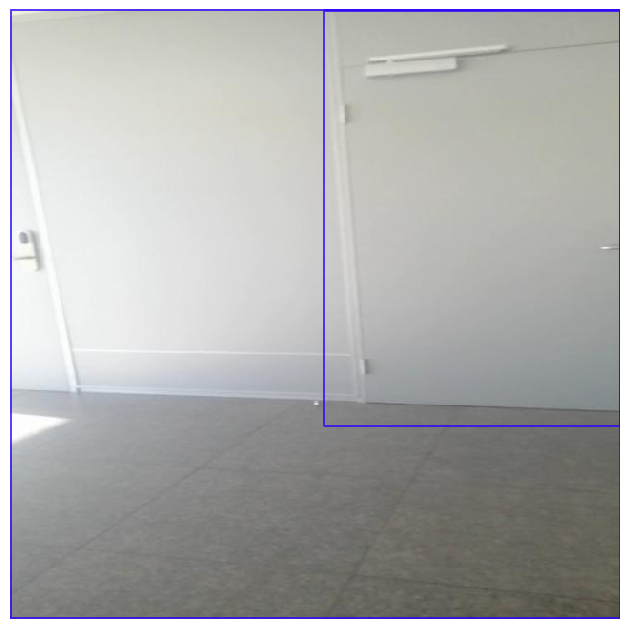

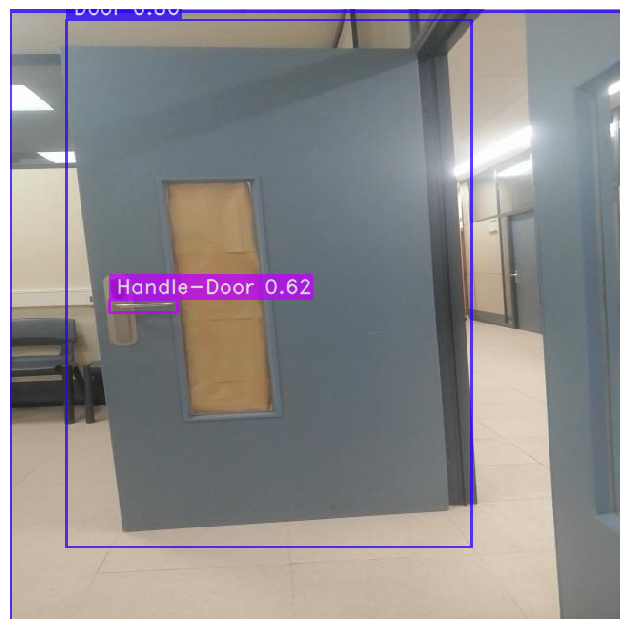

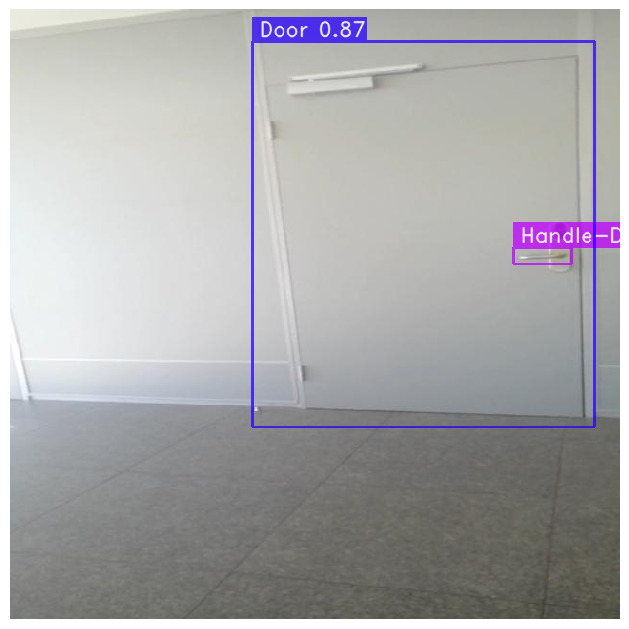

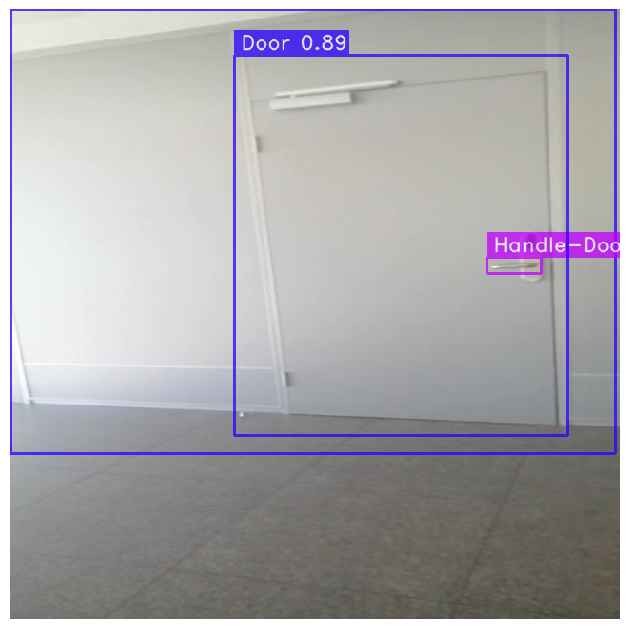

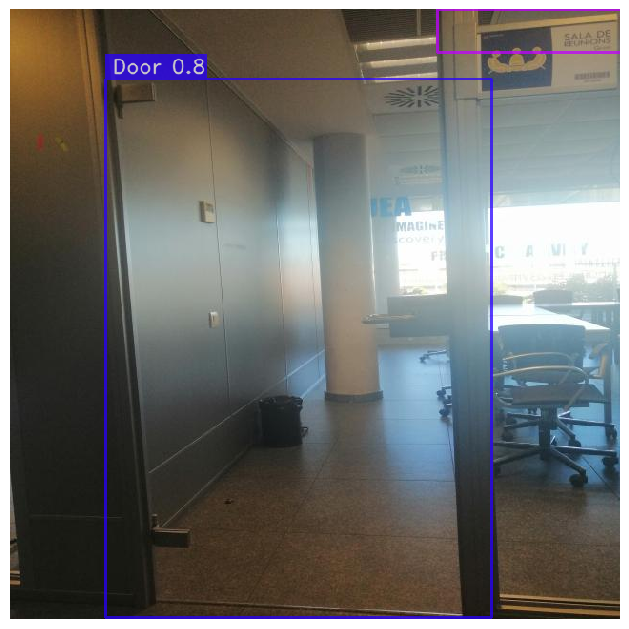

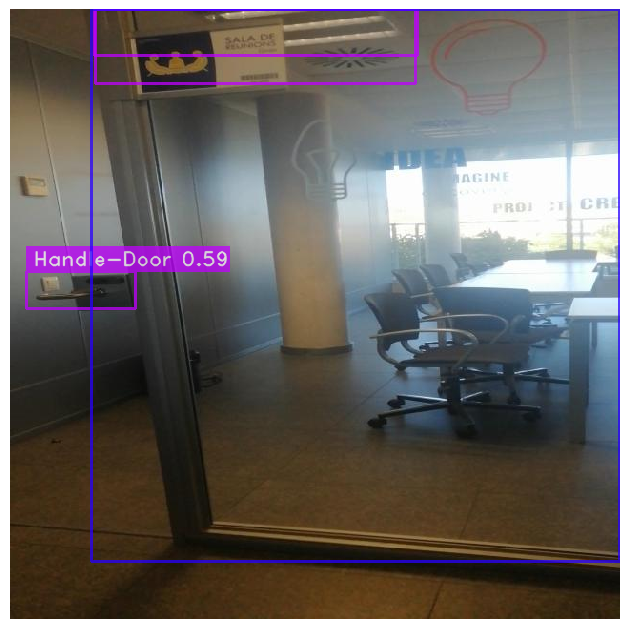

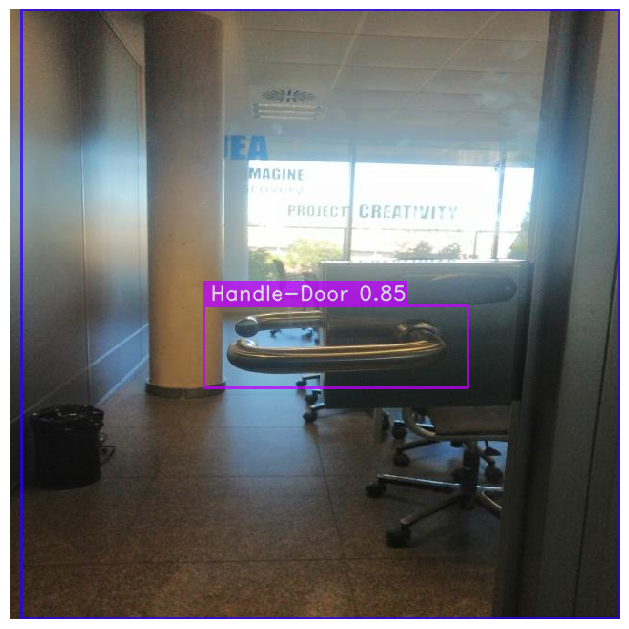

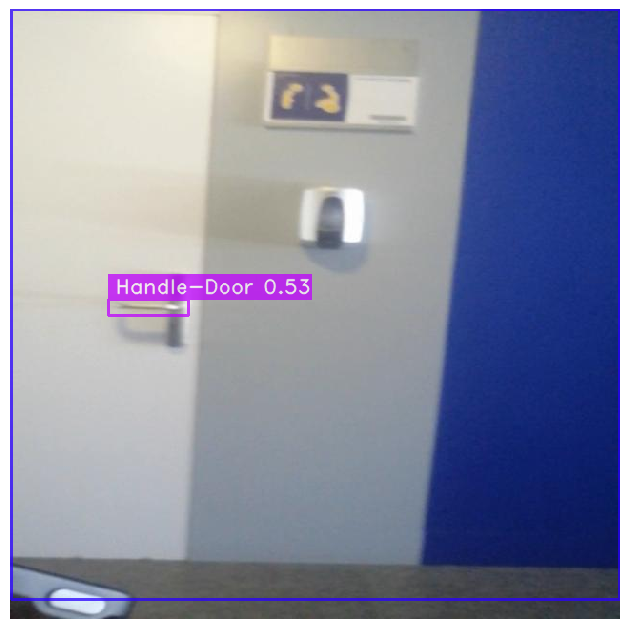

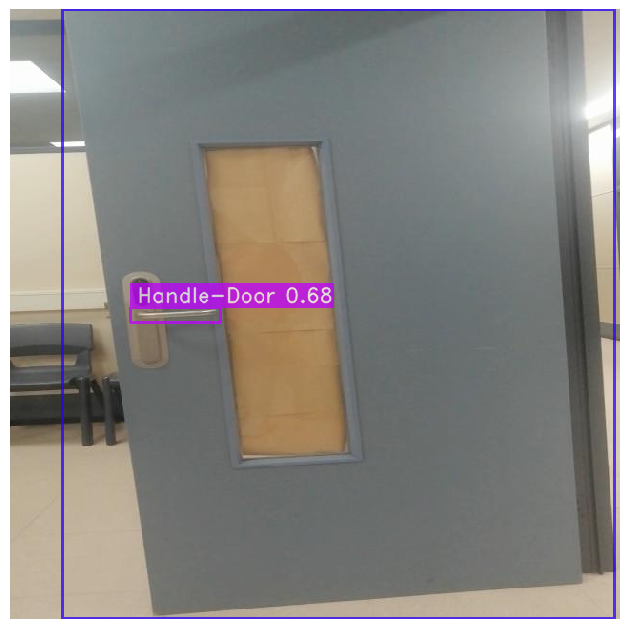

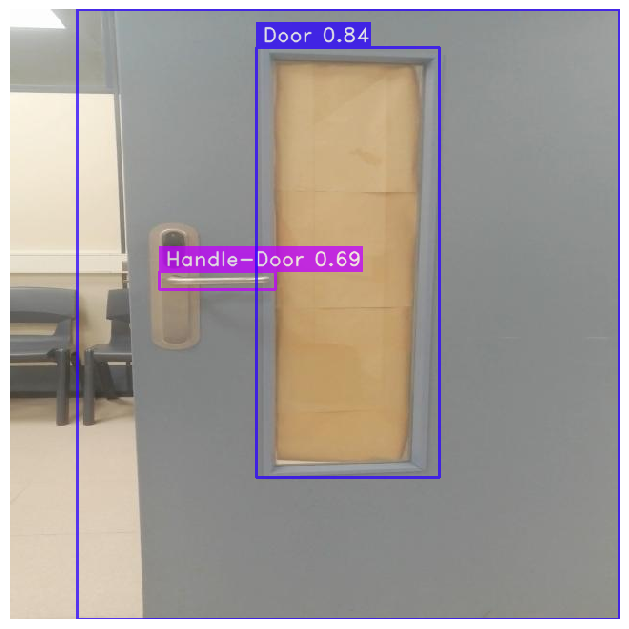

In [ ]:
print(outputs)
outputs.show()


Confusión Matrix

In [ ]:
#Inference
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_t.location}/test/images",
    annotations_directory_path=f"{dataset_t.location}/test/labels",
    data_yaml_path=f"{dataset_t.location}/data.yaml",
    force_masks=False
)

In [ ]:
#wITH A CONFIDENCE UMBRAL tresholf of 0.5, In this lines I will take the images that are up of 50% of predection from the test dataset
# I took coordinates, result of prediction, and the number (0 or 1) of the class for each image in test dataset
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2023-11-23 21:15:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-23 21:15:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-23 21:15:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-23 21:15:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-23 21:15:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-23 21:15:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-23 21:15:19] INFO -

Visualize inference result

In [ ]:
import random
random.seed(10)

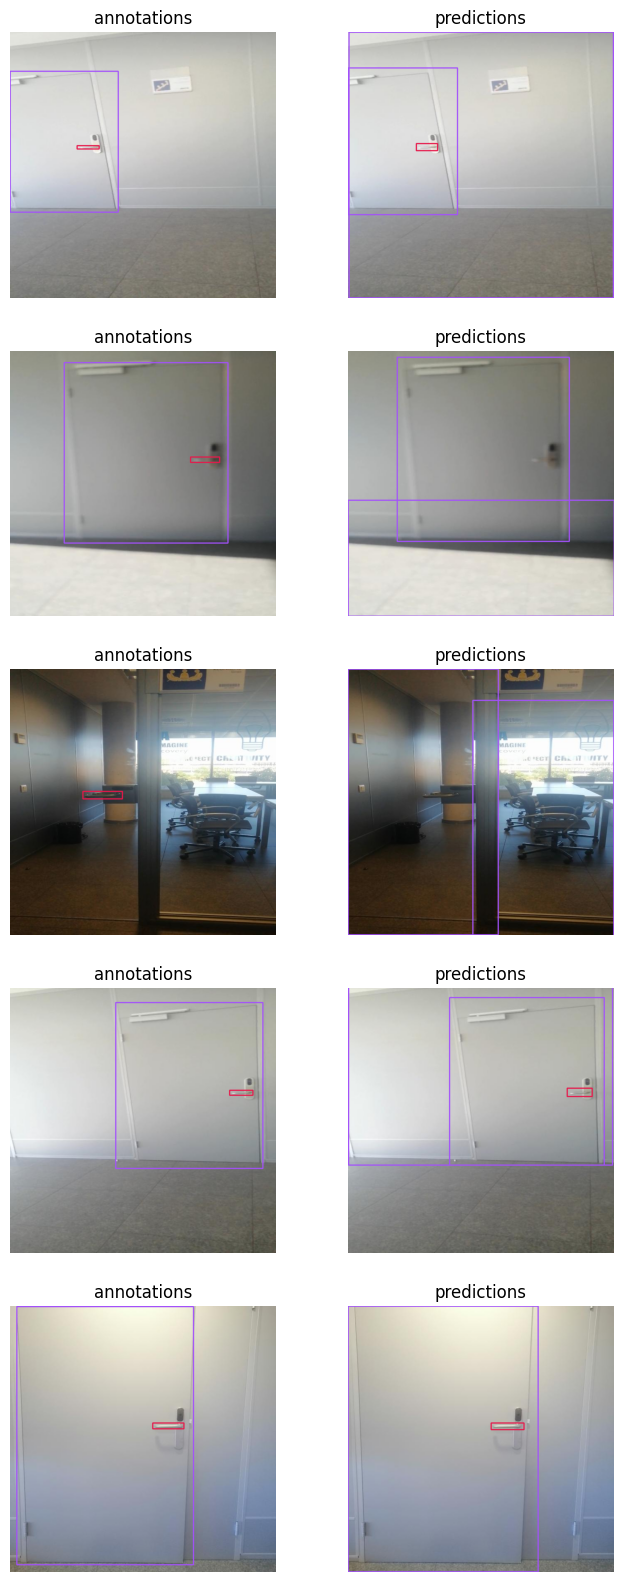

In [ ]:
import supervision as sv

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

Calculating confusion matrix

In [ ]:
# Intenta configurar el locale de forma diferente
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8

In [ ]:
!pip install onemetric

In [ ]:
import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=ds.classes)


#**Playing with treshold 0.50**

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.5,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 9/9 [00:13<00:00,  1.49s/it]


{'PPYoloELoss/loss_cls': 0.9272267,
 'PPYoloELoss/loss_iou': 0.19600756,
 'PPYoloELoss/loss_dfl': 0.96205187,
 'PPYoloELoss/loss': 1.8982722,
 'Precision@0.50': 0.5937390327453613,
 'Recall@0.50': 0.7752566337585449,
 'mAP@0.50': 0.6852868795394897,
 'F1@0.50': 0.6620689630508423}

In [ ]:
#Selecting a random image from path image
import cv2
import numpy as np
import os
import random

#path to the directory containing images
path_img = ("/content/Test_Door_Handle_Detection-2/test/images/")

#List all images in the directory
file_img = os.listdir(path_img)

#Selecting a random subset of images from the list (file_imgs)
selected_imgs = random.sample(file_img, k=10)

#initialize a list to store the loaded images
images = []

#Loop through the selected image file names, read and convert in RGB color
for img_file in selected_imgs:
  img_path = os.path.join(path_img, img_file) #recreating path file complete name
  img = cv2.imread(img_path)  #Uploading images in cv2 format
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converting in RGB color

  if img is not None:
    images.append(img) #Adding image selected in "images" list
  else:
    print(f"Failed to load image: {img_file}")

In [ ]:
outputs = best_model.predict(images)

Predicting Images:   0%|          | 0/10 [00:00<?, ?it/s][2023-11-23 21:31:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [ ]:
print(outputs)
outputs.show()

ImagesDetectionPrediction(_images_prediction_lst=[ImageDetectionPrediction(image=array([[[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [134, 138, 137],
        [134, 138, 137],
        [134, 138, 137]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [134, 138, 137],
        [134, 138, 137],
        [134, 138, 137]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [134, 138, 137],
        [134, 138, 137],
        [134, 138, 137]],

       ...,

       [[213, 198, 179],
        [213, 198, 179],
        [213, 198, 179],
        ...,
        [125, 126, 121],
        [125, 126, 121],
        [125, 126, 121]],

       [[214, 199, 180],
        [214, 199, 180],
        [214, 199, 180],
        ...,
        [125, 126, 121],
        [125, 126, 121],
        [125, 126, 121]],

       [[214, 199, 180],
        [214, 199, 180],
        [215, 200, 181],
      

#**cONFUSION MATRIX**

In [ ]:
#CONFUSION MATRIX
#Inference
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_t.location}/test/images",
    annotations_directory_path=f"{dataset_t.location}/test/labels",
    data_yaml_path=f"{dataset_t.location}/data.yaml",
    force_masks=False
)

In [ ]:
#wITH A CONFIDENCE UMBRAL tresholf of 0.5, In this lines I will take the images that are up of 50% of predection from the test dataset
# I took coordinates, result of prediction, and the number (0 or 1) of the class for each image in test dataset
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

In [ ]:
import random
random.seed(10)

In [ ]:
import supervision as sv

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install onemetric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=ds.classes)